# **Name :** Shubham Gupta
# **Roll No. :** AIML/2021/046
# **University Roll :** 11600921049

**<h1><center>Advanced Machine Learning</center></h1>**

**<h2>Sentiment Analysis on Amazon Food Reviews</h2>**

## **Abstract:**
*Sentiment analysis, also referred to as opinion mining, stands as a fundamental natural language processing (NLP) task aimed at deciphering sentiment expressed within text. The overarching objective is to discern whether the conveyed opinion is positive, negative, or neutral. This analytical pursuit finds broad application across diverse domains, spanning customer reviews, social media surveillance, market analysis, and food critique. This project centers on the exploration of Amazon food reviews from customers, with a primary aim to forecast whether a review leans towards positivity or negativity. The dataset comprises customer reviews alongside metrics such as upvotes and total votes garnered by those comments. Leveraging techniques including Bag of Words (BoW), Term Frequency-Inverse Document Frequency (TFIDF), and N-grams, the project seeks to distill insights from the textual data, enabling the prediction of user sentiments regarding Amazon food products.*

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import re
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Import Data**

In [ ]:
url = '/content/drive/MyDrive/LAB-6th Semester/Advanced Machine Learning/Sentiment Analysis on Amazon Food Reviews/Reviews.csv'
data = pd.read_csv(url)

In [ ]:
data['Helpful %'] = np.where(data['HelpfulnessDenominator'] > 0,
                             data['HelpfulnessNumerator'] / data['HelpfulnessDenominator'],
                             -1)
data['% Upvote'] = pd.cut(data['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
                          labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'],
                          include_lowest = True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1.0, 'How helpful users find among user scores')

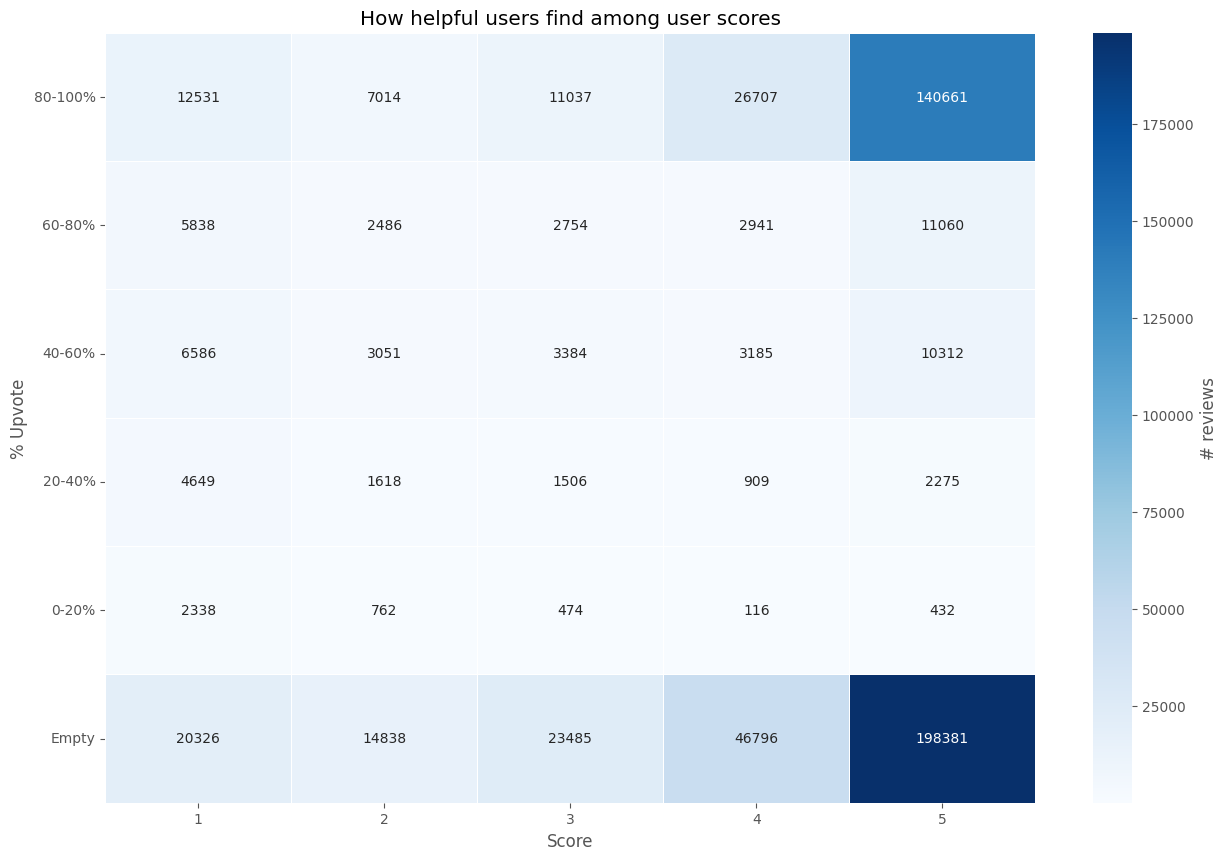

In [ ]:
df_s = data.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'Blues',
            linewidths=.5, annot = True, fmt = 'd',
            cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

*Key message from above:*

* Reviews are skewed towards positive
* More than half of the reviews are with zero votes
* Many people agree with score 5 reviews

***Then we get rid of score 3 reviews (neutral), and separate the remaining reviews into binary class (1 = positive, 0 = negative):***

In [ ]:
df = data[data['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

**Score Prediction**

In [ ]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):

    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))

    if coef_show == 1:
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')
        print(coeff_df.tail(20).to_string(index=False))


text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9357874237375812

-Top 20 positive-
       Word  Coefficient
 pleasantly     4.233988
   downside     3.126420
  addicting     2.959068
   drawback     2.670239
  skeptical     2.511270
     resist     2.379871
 economical     2.265789
       whim     2.236301
   soothing     2.218977
    easiest     2.206777
     hooked     2.174912
    welcome     2.084585
  delighted     2.079272
      meets     1.976601
        yay     1.976106
wonderfully     1.970862
  excellent     1.965659
    worries     1.945496
exceptional     1.942430
     delish     1.933981

-Top 20 negative-
         Word  Coefficient
        ruins    -2.306015
       lacked    -2.327670
        blech    -2.334804
   unfinished    -2.350162
   unbearable    -2.356371
          ick    -2.419503
   overpowers    -2.489050
  unappealing    -2.531981
  disapointed    -2.558029
      defeats    -2.614594
   returnable    -2.684543
     mediocre    -2.736155
       ripoff    -2.843889
disappointing    -2.9432

In [ ]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.8437324082949168


**Logistic regression model on TFIDF**

In [ ]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9347528412980967

-Top 20 positive-
      Word  Coefficient
     great    13.829271
 delicious    12.266400
      best    11.950646
   perfect    10.603334
 excellent     9.912412
     loves     9.589463
    highly     8.900379
      love     8.377649
 wonderful     8.016587
   amazing     7.610002
pleasantly     7.505516
   awesome     7.374907
      good     7.331522
      nice     7.140911
    hooked     7.140227
  favorite     6.901615
   pleased     6.833933
    smooth     6.811193
     yummy     6.728316
 fantastic     6.521717

-Top 20 negative-
          Word  Coefficient
  unacceptable    -5.621037
          poor    -5.689809
          yuck    -5.885682
   undrinkable    -5.934016
         worse    -6.123684
         stale    -6.125437
         bland    -6.378601
    disgusting    -6.411666
          weak    -6.466382
         threw    -6.658506
     tasteless    -6.660641
        return    -6.753367
 unfortunately    -7.482973
      horrible    -7.829670
dis

**Logistic regression model on TFIDF + ngram**

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9457604941652593

-Top 20 positive-
     Word  Coefficient
    great    20.855565
     best    17.937496
delicious    17.013618
  perfect    14.556857
    loves    13.740189
     love    13.215917
excellent    13.073653
     good    11.469407
wonderful    11.238944
     nice    10.906891
 favorite    10.679330
  amazing     9.604788
  awesome     9.298551
     easy     9.169952
    happy     8.978891
  pleased     8.815757
   smooth     8.639700
    yummy     8.542115
    tasty     8.471431
   highly     8.434181

-Top 20 negative-
          Word  Coefficient
         maybe    -7.892227
        hoping    -8.070309
     tasteless    -8.229962
         money    -8.262063
         worse    -8.301065
       thought    -8.488736
    disgusting    -8.713986
         bland    -9.136684
         threw    -9.280872
         stale    -9.982482
          weak   -10.106826
        return   -10.123877
disappointment   -10.315521
 unfortunately   -10.813910
      horrible   -11.312

**<h4>Upvote Prediction</h4>**

In [ ]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class Distribution:')
print(y.value_counts())

Class Distribution:
1.0    151721
0.0      2707
Name: % Upvote, dtype: int64


In [ ]:
df_s = pd.DataFrame(data=[X, y]).T

# Get indices for downvote and upvote records
Downvote_indices = df_s[df_s['% Upvote'] == 0].index  # Use label-based indexing
Upvote_indices = df_s[df_s['% Upvote'] == 1].index

# Randomly select upvote records for undersampling
random_upvote_indices = np.random.choice(Upvote_indices, len(Downvote_indices), replace=False)
under_sample_indices = np.concatenate([Downvote_indices, random_upvote_indices])

# Create under-sampled DataFrame using iloc for position-based indexing
under_sample_data = df_s.loc[under_sample_indices, :]

# Extract features and target variable
X_u = under_sample_data['Text']
y_u = under_sample_data['% Upvote'].astype(int)

# Calculate and print statistics
print("Percentage of upvote transactions:", len(under_sample_data[under_sample_data['% Upvote'] == 1]) / len(under_sample_data))
print("Percentage of downvote transactions:", len(under_sample_data[under_sample_data['% Upvote'] == 0]) / len(under_sample_data))
print("Total number of records in resampled data:", len(under_sample_data))


Percentage of upvote transactions: 0.5
Percentage of downvote transactions: 0.5
Total number of records in resampled data: 5414


**Logistic regression model on word count**

In [ ]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 15745
# train records: 4060
# test records: 1354
Model Accuracy: 0.7134416543574594

-Top 20 positive-
       Word  Coefficient
      dates     1.275721
   flavored     1.273786
     prices     1.257337
       chai     1.235854
considering     1.202196
     plenty     1.196584
       kick     1.189244
   benefits     1.178506
      value     1.168659
      puppy     1.154867
      salty     1.151921
   american     1.145928
     sticks     1.104899
     single     1.097642
     keurig     1.096394
      saver     1.095273
      worth     1.095032
  favorites     1.090147
       stir     1.088250
        com     1.086361

-Top 20 negative-
    Word  Coefficient
     ate    -1.013635
   hubby    -1.032375
   purse    -1.039332
 totally    -1.058632
  joints    -1.077092
  square    -1.085569
  middle    -1.090151
  pricey    -1.091368
   party    -1.114622
  barley    -1.115661
 cleanse    -1.141081
brooklyn    -1.141854
    zico    -1.152459
   kashi    -1.164554
    hand   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic regression model on TFIDF + ngram**

In [ ]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 140672
# train records: 4060
# test records: 1354
Model Accuracy: 0.7333825701624815

-Top 20 positive-
   Word  Coefficient
   food     1.596112
 flavor     1.452315
   salt     1.340173
 gluten     1.294370
   just     1.288771
   make     1.224861
  salty     1.210191
   teas     1.199982
   rice     1.135051
    try     1.109870
    lot     1.102065
  bread     1.083264
chicken     1.059570
  worth     1.050333
perfect     1.024729
    dog     1.008582
     ve     0.992524
    mix     0.988108
  store     0.962721
  value     0.948163

-Top 20 negative-
      Word  Coefficient
    thanks    -0.836736
     items    -0.843165
       don    -0.845514
       say    -0.860272
      yoga    -0.893290
    people    -0.918633
      want    -0.920597
cappuccino    -0.937418
    lipton    -0.985092
      item    -0.990022
  received    -1.047606
    marley    -1.073496
   service    -1.139580
     order    -1.264744
      zico    -1.275392
   product    -1.334422
    coffee    -1

***Non-Context Features***

In [ ]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
24479     We have a Frenchie with all kinds of skin prob...
498450    This coffer is served at my local Italian club...
546091    Love to have these on hand for the whole famil...
568376    This is the best product we have found for mak...
63073     My girlfriend told me about this seasoning, an...
Name: Text, dtype: object


**Feature of words**

In [ ]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                0.0        1.0
word_count        83.927226  86.009235
capital_count     19.252678  14.097156
question_mark      0.180273   0.064278
exclamation_mark   0.906169   0.990026
punctuation       22.482822  19.210565


<h3>Model Prediction by Logistic and SVM Classifier</h3>

In [ ]:
# Check and correct the data type of y_num if necessary
if not pd.api.types.is_integer_dtype(y_num):  # Or use isinstance(y_num, (np.ndarray, pd.Series))
    y_num = y_num.astype(int)

# Handle missing values if present
if pd.isna(y_num).any():
    # Choose an appropriate strategy to handle missing values
    y_num = y_num.fillna(y_num.mean())  # Example: Impute with mean

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

# Train and evaluate the models
clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))


Logistic Regression accuracy: 0.5878877400295421
SVM accuracy: 0.5827178729689808


**User's Behaviour**

In [ ]:
df_user = data.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


**Review of User**

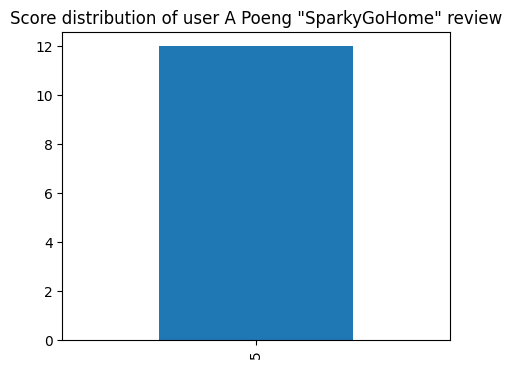

In [ ]:
def plot_user(UserId):
    df_1user = data[data['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (5,4),
                            title = 'Score distribution of user {} review'.format(data[data['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A2725IB4YY9JEB')

**Neutral User's**

In [ ]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


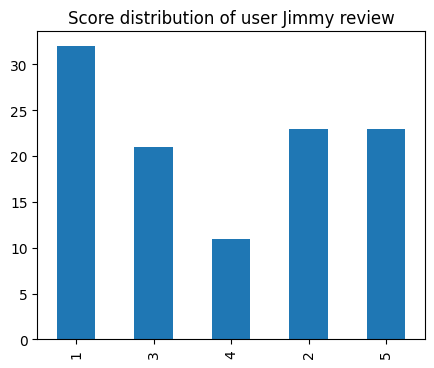

In [ ]:
plot_user('A2TN9C5E4A0I3F')

In [ ]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = data[(data['UserId'] == userid) & (data['Score'] == score)]['Text']
    else:
        df = data[data['Score'] == score]['Text']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)

    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
                    Phrase  Count Occur %
0             (never, buy)     11  42.31%
1           (buy, product)      9  34.62%
2  (monosodium, glutamate)      8  30.77%
3    (never, buy, product)      8  30.77%
4            (decide, try)      7  26.92%
5          (picture, look)      7  26.92%
6         (dry, tasteless)      7  26.92%
score 2 reviews most popular 2-gram / 3-gram:
                  Phrase  Count Occur %
0          (sauce, ruin)      8  47.06%
1   (sauce, ruin, whole)      8  47.06%
2          (ruin, whole)      8  47.06%
3            (give, try)      7  41.18%
4        (product, ever)      6  35.29%
5             (n't, buy)      6  35.29%
6      (n't, get, wrong)      5  29.41%
7      (...., give, try)      5  29.41%
8      (buy, particular)      5  29.41%
9            (try, like)      5  29.41%
10         (taste, like)      5  29.41%
11          (get, wrong)      5  29.41%
12            (n't, get)      5  29.41%
13     (give

<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: Futu

score 4 reviews most popular 2-gram / 3-gram:
                Phrase  Count Occur %
0  (highly, recommend)      6   37.5%
1         (side, dish)      5  31.25%
2       (potato, chip)      4   25.0%
score 5 reviews most popular 2-gram / 3-gram:
                Phrase  Count Occur %
0  (highly, recommend)     18  42.86%


<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-31-f8f6a2618bcd>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)


In [ ]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   5547  10.61%
1  (waste, money)   2330   4.46%
2    (could, n't)   2175   4.16%
3     (n't, even)   2111   4.04%
4     (n't, know)   1809   3.46%
5    (would, n't)   1794   3.43%
6      (n't, buy)   1645   3.15%


<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: Futu

score 2 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   3161  10.62%
1     (n't, like)   1362   4.58%
2    (would, n't)   1304   4.38%
3  (think, would)   1086   3.65%
4      (n't, buy)   1064   3.57%
5     (n't, know)   1010   3.39%
6    (n't, taste)    996   3.35%
7    (could, n't)    945   3.17%
8   (taste, good)    912   3.06%


<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: Futu

score 3 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   3240    7.6%
1    (would, n't)   1632   3.83%
2     (n't, like)   1612   3.78%
3   (taste, good)   1557   3.65%
4   (href=, http)   1463   3.43%
5     (n't, know)   1406    3.3%
6  (think, would)   1301   3.05%


<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: Futu

score 4 reviews most popular 2-gram / 3-gram:
           Phrase  Count Occur %
0   (taste, like)   4358    5.4%
1   (taste, good)   3207   3.98%
2   (href=, http)   3011   3.73%
3  (pretty, good)   2821    3.5%
4  (really, like)   2743    3.4%
5     (n't, like)   2428   3.01%


<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: Futu

score 5 reviews most popular 2-gram / 3-gram:
                Phrase  Count Occur %
0  (highly, recommend)  17542   4.83%
1        (taste, like)  14458   3.98%
2     (grocery, store)  11772   3.24%
3       (taste, great)  11516   3.17%


<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-33-e273db6451c3>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)


In [ ]:
def get_token_adj(score, benchmark, userid='all'):

    if userid != 'all':
        df = data[(data['UserId'] == userid) & (data['Score'] == score)]['Text']
    else:
        df = data[data['Score'] == score]['Text']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']

    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)

    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [ ]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Phrase  Count Occur %
0        dry     13   50.0%
1     cheese     12  46.15%
2        bad     10  38.46%
3     little     10  38.46%
4  delicious      8  30.77%
5  expensive      8  30.77%
6       hard      8  30.77%
7      tasty      8  30.77%
8      bread      7  26.92%
9       poor      7  26.92%
score 2 reviews most popular adjectives word:
       Phrase  Count Occur %
0       whole     10  58.82%
1      cheese      8  47.06%
2       wrong      6  35.29%
3   delicious      6  35.29%
4       awful      6  35.29%
5        good      5  29.41%
6  particular      5  29.41%


<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWar

score 3 reviews most popular adjectives word:
         Phrase  Count Occur %
0         whole      9  64.29%
1          high      5  35.71%
2          good      4  28.57%
3         great      4  28.57%
4  disappointed      4  28.57%
5         first      4  28.57%
score 4 reviews most popular adjectives word:
      Phrase  Count Occur %
0      great      9  56.25%
1  delicious      8   50.0%
2  recommend      5  31.25%
3     little      5  31.25%
4       good      4   25.0%
5   multiple      4   25.0%
6       high      4   25.0%
7       much      4   25.0%
8    regular      4   25.0%


<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWar

score 5 reviews most popular adjectives word:
      Phrase  Count Occur %
0  delicious     31  73.81%
1      great     18  42.86%
2       high     14  33.33%
3      first     13  30.95%
4      fresh     12  28.57%


<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-35-b9e975926c53>:9: FutureWar

In [ ]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
          Phrase  Count Occur %
0           good  16216  31.02%
1            bad  10804  20.67%
2          great   4984   9.54%
3           much   4840   9.26%
4         little   4787   9.16%
5            old   4781   9.15%
6          first   4201   8.04%
7            new   3963   7.58%
8      different   3789   7.25%
9           many   3717   7.11%
10         small   3540   6.77%
11          real   3297   6.31%
12  disappointed   2999   5.74%
13          sure   2889   5.53%
14          free   2835   5.42%
15          diet   2832   5.42%
16          high   2769    5.3%
17          last   2659   5.09%


<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWar

score 2 reviews most popular adjectives word:
          Phrase  Count Occur %
0           good  13542  45.49%
1           much   4252  14.28%
2            bad   4198   14.1%
3          great   3918  13.16%
4         little   3691   12.4%
5          small   2848   9.57%
6          first   2318   7.79%
7         strong   2293    7.7%
8      different   2242   7.53%
9          sweet   2165   7.27%
10          many   2068   6.95%
11           old   2056   6.91%
12           big   2010   6.75%
13          hard   1952   6.56%
14           hot   1925   6.47%
15  disappointed   1908   6.41%
16          sure   1900   6.38%
17          high   1893   6.36%
18         green   1767   5.94%
19         whole   1704   5.72%
20       healthy   1644   5.52%
21           new   1608    5.4%
22          weak   1595   5.36%
23       organic   1576   5.29%
24          real   1527   5.13%
25       regular   1495   5.02%


<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWar

score 3 reviews most popular adjectives word:
       Phrase  Count Occur %
0        good  25117   58.9%
1       great   7654  17.95%
2      little   7374  17.29%
3        much   6926  16.24%
4         bad   5497  12.89%
5      strong   4744  11.13%
6       small   4683  10.98%
7       sweet   4015   9.42%
8       first   3468   8.13%
9   different   3434   8.05%
10       high   3289   7.71%
11       nice   3108   7.29%
12       sure   3103   7.28%
13        big   3041   7.13%
14        hot   2918   6.84%
15       many   2904   6.81%
16      green   2762   6.48%
17    healthy   2672   6.27%
18    organic   2608   6.12%
19       hard   2601    6.1%
20    regular   2568   6.02%
21        old   2520   5.91%
22      large   2516    5.9%
23      whole   2247   5.27%
24    natural   2237   5.25%
25        dry   2164   5.08%


<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWar

score 4 reviews most popular adjectives word:
       Phrase  Count Occur %
0        good  52577  65.19%
1       great  22480  27.87%
2      little  16209   20.1%
3        much  10530  13.06%
4        nice   9281  11.51%
5      strong   8536  10.58%
6       small   8375  10.38%
7       sweet   8156  10.11%
8     healthy   6495   8.05%
9        easy   6152   7.63%
10        hot   5980   7.41%
11       high   5962   7.39%
12       many   5734   7.11%
13        bad   5683   7.05%
14        big   5682   7.04%
15  different   5480   6.79%
16      first   5426   6.73%
17    organic   5309   6.58%
18       sure   5047   6.26%
19       free   5033   6.24%
20      green   4839    6.0%
21    regular   4764   5.91%
22      large   4654   5.77%
23       hard   4573   5.67%
24        old   4499   5.58%
25      tasty   4474   5.55%
26      fresh   4464   5.53%
27        low   4406   5.46%
28      whole   4326   5.36%
29  delicious   4326   5.36%
30    natural   4268   5.29%


<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWar

score 5 reviews most popular adjectives word:
       Phrase   Count Occur %
0        good  151290  41.66%
1       great  127849  35.21%
2      little   45683  12.58%
3        much   32777   9.03%
4   delicious   32744   9.02%
5     healthy   30182   8.31%
6        many   27711   7.63%
7        free   26172   7.21%
8        easy   25850   7.12%
9    favorite   25257   6.96%
10      small   24898   6.86%
11        hot   24759   6.82%
12      sweet   23771   6.55%
13       nice   23228    6.4%
14        old   21403   5.89%
15      happy   21162   5.83%
16      fresh   20424   5.62%
17     strong   20269   5.58%
18    organic   19768   5.44%
19       high   19727   5.43%
20  different   19348   5.33%
21      first   18844   5.19%
22      local   18735   5.16%
23    perfect   18649   5.14%
24        big   18319   5.04%


<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test.append(pd.Series(i, index = index), ignore_index = True)
<ipython-input-36-b55fac0439cf>:9: FutureWar

**Model Review Prediction**

In [ ]:
# Filter out reviews with a score of 3
df = data.copy()

# Define features and labels
df['Sentiment'] = df['Score'].map({1: 'negative', 2: 'slightly negative', 3: 'neutral', 4: 'slightly positive', 5: 'positive'})
X = df['Text']
y = df['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer with n-grams
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression with TF-IDF Vectorizer
logreg_model_tfidf = LogisticRegression(max_iter=1000)
logreg_model_tfidf.fit(X_train_tfidf, y_train)

# Save the model and vectorizer as .pkl files
joblib.dump(logreg_model_tfidf, "logreg_model_tfidf.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

print("Model trained and saved successfully!")

Model trained and saved successfully!


*Saved the model - trained files to drive.*

In [ ]:
# Load the trained model and vectorizer
logreg_model = joblib.load("/content/drive/MyDrive/LAB-6th Semester/Advanced Machine Learning/Sentiment Analysis on Amazon Food Reviews/logreg_model_tfidf.pkl")
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/LAB-6th Semester/Advanced Machine Learning/Sentiment Analysis on Amazon Food Reviews/tfidf_vectorizer.pkl")

print("Welcome to the review sentiment prediction system!")
print("Enter a review or type 'exit' to quit.")

while True:
    # Prompt user for input
    review = input("Enter a review: ")

    # Check if the user wants to exit
    if review.lower() == 'exit':
        print("Exiting the program.")
        break

    # Transform the review using the TF-IDF Vectorizer
    review_tfidf = tfidf_vectorizer.transform([review])

    # Predict sentiment using the Logistic Regression model
    predicted_sentiment = logreg_model.predict(review_tfidf)[0]

    # Display the prediction
    print("Logistic Regression predicts the sentiment as:", predicted_sentiment)

Welcome to the review sentiment prediction system!
Enter a review or type 'exit' to quit.
Enter a review: Not good 
Logistic Regression predicts the sentiment as: slightly positive
Enter a review: Product is good but not for kids
Logistic Regression predicts the sentiment as: positive
Enter a review: Sex sux
Logistic Regression predicts the sentiment as: positive
Enter a review: Hellooo
Logistic Regression predicts the sentiment as: positive


**Quick EDA**

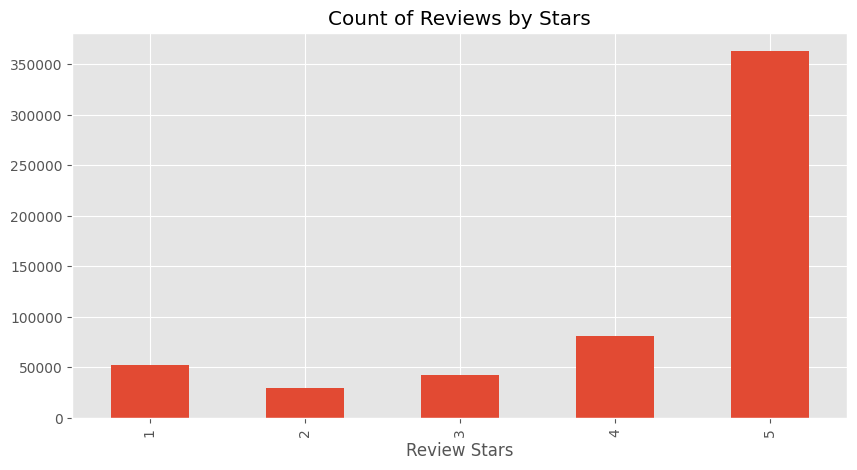

In [ ]:
ax = data['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [ ]:
example = data['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# **VADER Sentiment Scoring**

Here, the NLTK's *Sentiment-Intensity-Analyzer* to get the neg/neu/pos scores of the text.

- This uses a "Bag Of Words" approach:
    1. Stop words are removed
    2. Each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(data, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


## **Plot VADER Results**

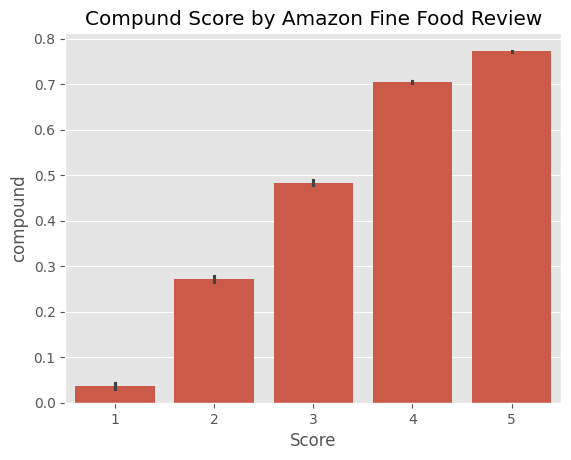

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Fine Food Review')
plt.show()

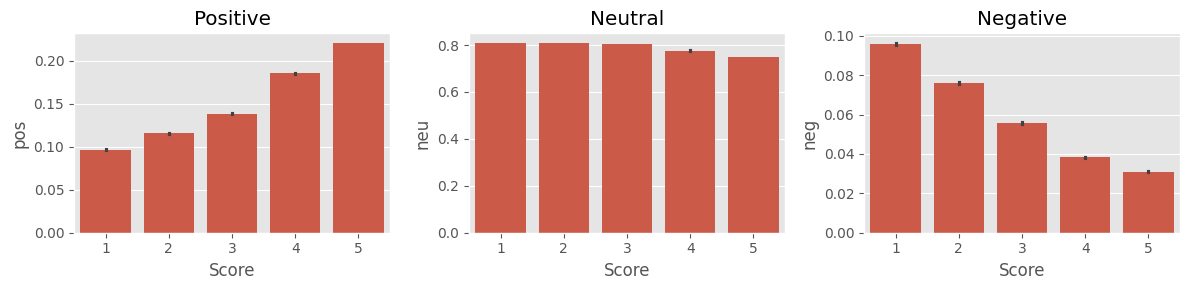

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [ ]:
# Define a function to categorize sentiment
def categorize_sentiment(compound_score):
    if compound_score >= 0.6:
        return 'Strongly Positive'
    elif compound_score >= 0.1:
        return 'Slightly Positive'
    elif compound_score <= -0.6:
        return 'Strongly Negative'
    elif compound_score <= -0.1:
        return 'Slightly Negative'
    else:
        return 'Neutral'

# Loop to allow user input and perform sentiment analysis
while True:
    # Get user input
    text = input("Enter a text to analyze sentiment (or 'exit' to quit): ")

    # Check if the user wants to exit
    if text.lower() == 'exit':
        break

    # Perform sentiment analysis using VADER
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']

    # Categorize sentiment
    sentiment = categorize_sentiment(compound_score)

    # Display results
    print(f"Text: {text}")
    print(f"Positive: {scores['pos']}, Negative: {scores['neg']}, Neutral: {scores['neu']}, Compound: {compound_score}")
    print(f"Sentiment: {sentiment}\n")

Text: Good Product
Positive: 0.744, Negative: 0.0, Neutral: 0.256, Compound: 0.4404
Sentiment: Slightly Positive

Text: Thinking not too buy
Positive: 0.0, Negative: 0.0, Neutral: 1.0, Compound: 0.0
Sentiment: Neutral

Text: Bad in quality
Positive: 0.0, Negative: 0.636, Neutral: 0.364, Compound: -0.5423
Sentiment: Slightly Negative



# Hugging-Face: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# LSTM

Performing **<b>Long Short-Term Memory (LSTM)</b>** networks are a type of recurrent neural network (RNN) architecture that is well-suited for handling sequential data due to their ability to capture long-term dependencies and handle vanishing or exploding gradients. When applied to sentiment analysis, LSTM networks excel at understanding the context and relationships between words in a sentence, thereby capturing the sentiment expressed within the text.

**Import Data**

In [ ]:
url = '/content/drive/MyDrive/LAB-6th Semester/Advanced Machine Learning/Sentiment Analysis on Amazon Food Reviews/Reviews.csv'
df = pd.read_csv(url)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df=df[['Text','Score']]
df['review']=df['Text']
df['label']=df['Score']
df.drop(['Text','Score'],axis=1,inplace=True)

<ipython-input-67-5ae209e3daad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review']=df['Text']
<ipython-input-67-5ae209e3daad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['Score']
<ipython-input-67-5ae209e3daad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Text','Score'],axis=1,in

In [ ]:
df.head(5)

,review,label
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
 # drop rating values 3 reviews, neutral reviews
df = df[df['label'] != 3]

In [ ]:
def mark_sentiment(rating):
    if(rating<3):
        return 0 # negative
    else:
        return 1 # positive
df['label']=df['label'].apply(mark_sentiment)

In [ ]:
df['label'].head(5)

0    1
1    0
2    1
3    0
4    1
Name: label, dtype: int64

In [ ]:
# check missing value and duplicates
print(df['label'].isnull().sum())
df['review'].isnull().sum()
df.drop_duplicates(subset=['label','review'],keep='first',inplace=True)
pos_df=df.loc[df.label==1,:][:10000]
neg_df=df.loc[df.label==0,:][:10000]
df=pd.concat([pos_df,neg_df],ignore_index=True)
#perform a random shuffle.
'''It's a good practice to shuffle the data before splitting between a train and test set.
#That way the sentiment classes are equally distributed over the train and test sets.'''
#df = df.reindex(np.random.permutation(df.index))
df = df.sample(frac=1).reset_index(drop=True)

0


In [ ]:
df.head(2)

,review,label
0,This is the most horrible stuff. Bacon? PLEASE...,0
1,"Ordered malossol salmon caviar, received some ...",0


# Data Preprocesing

In [ ]:
df['review'] = df.review.apply(lambda x : x.lower())  # all reviews characters converts to lowercase
df['review'] = df.review.apply(lambda x: re.sub(r'\d+','', x))  # remove the numbers in reviews
df['review'] = df.review.apply(lambda x: re.sub(r'[^\w\s]', ' ',x)) # remove the punctuations in reviews
df['review'] = df.review.apply(lambda x: x.strip()) # remove whitespaces
x = df['review']
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Preparing the Embedding Layer

## Tokenizing the dataset

In [ ]:
tokenizer = Tokenizer(num_words=5000)  # Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode.
# we call fit_on_texts to create associations of words and numbers
tokenizer.fit_on_texts(x_train)


## Padding the dataset

In [ ]:
# After having created the dictionary we can convert the text to a list of integer indexes.
# This is done with the text_to_sequences method of the Tokenizer.
# calling text_to_sequence replaces the words in a sentence with their respective associated numbers.
# This transforms each sentence into sequences of numbers.
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
# The reviews have different number of words, therefore, the length of the sequence of numbers will be different.
# Our model requires inputs to have equal lengths, so we will have to pad the sequence to have the chosen length of inputs.
# This is done by calling the pad_sequence method with a length of 200.
vocab_size = len(tokenizer.word_index) + 1
max_review_length = 200

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
print(x_train.shape)

(16000, 200)


# Model 1

**Embedding --> LSTM --> Dense(Output(Sigmoid))**

In [ ]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 64s 498ms/step - loss: 0.5638 - accuracy: 0.7237 - val_loss: 0.3083 - val_accuracy: 0.8723
Epoch 2/5
125/125 [==============================] - 56s 447ms/step - loss: 0.2795 - accuracy: 0.8847 - val_loss: 0.2547 - val_accuracy: 0.8978
Epoch 3/5
125/125 [==============================] - 56s 447ms/step - loss: 0.2233 - accuracy: 0.9153 - val_loss: 0.2572 - val_accuracy: 0.8947
Epoch 4/5
125/125 [==============================] - 53s 419ms/step - loss: 0.1765 - accuracy: 0.9354 - val_loss: 0.2727 - val_accuracy: 0.8875
Epoch 5/5
125/125 [==============================] - 54s 430ms/step - loss: 0.1507 - accuracy: 0.9461 - val_loss: 0.3055 - val_accuracy: 0.8963
Test Score: 0.30553728342056274
Test Accuracy: 0.8962500095367432
Accuracy: 89.63%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


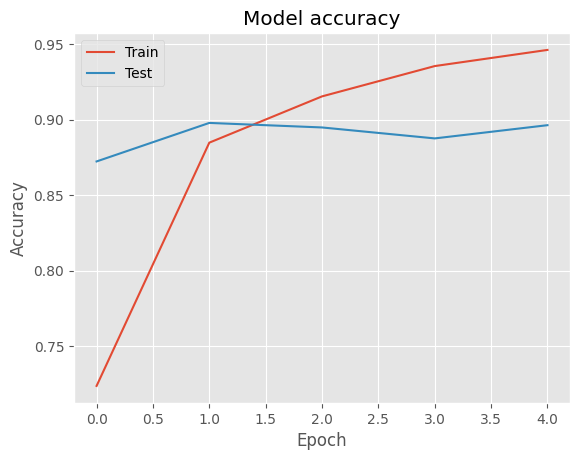

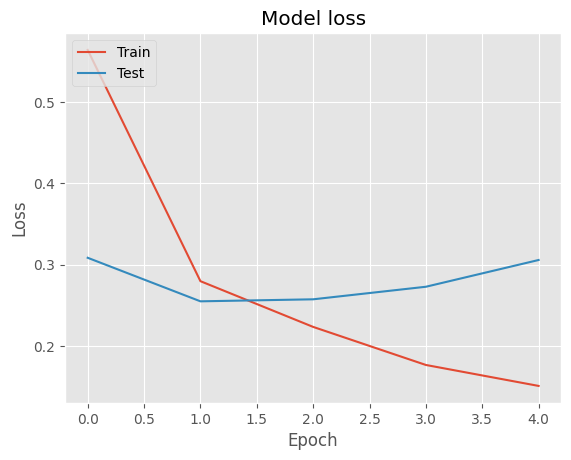

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 2

**Embedding --> LSTM --> Dense(Output(Sigmoid))**
- Same with Model 1 except optimization algorithm. In this study used Adadelta optimizer. With this model, the effect of optimization algorithm is observed.

In [ ]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 54s 422ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 2/5
125/125 [==============================] - 70s 559ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.4985
Epoch 3/5
125/125 [==============================] - 52s 415ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.4988
Epoch 4/5
125/125 [==============================] - 56s 452ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.4988
Epoch 5/5
125/125 [==============================] - 78s 623ms/step - loss: 0.6931 - accuracy: 0.5046 - val_loss: 0.6931 - val_accuracy: 0.4992
Test Score: 0.6931068897247314
Test Accuracy: 0.49924999475479126
Accuracy: 49.92%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


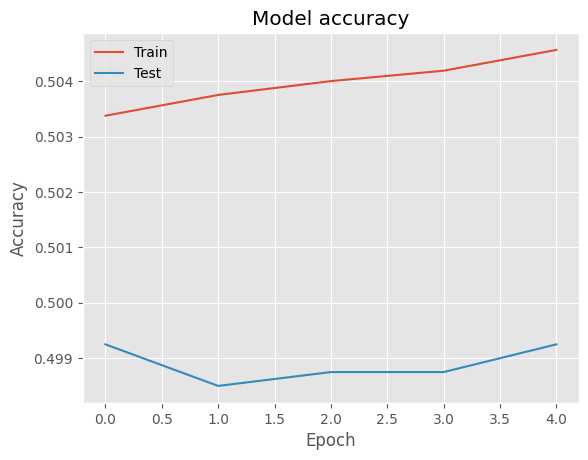

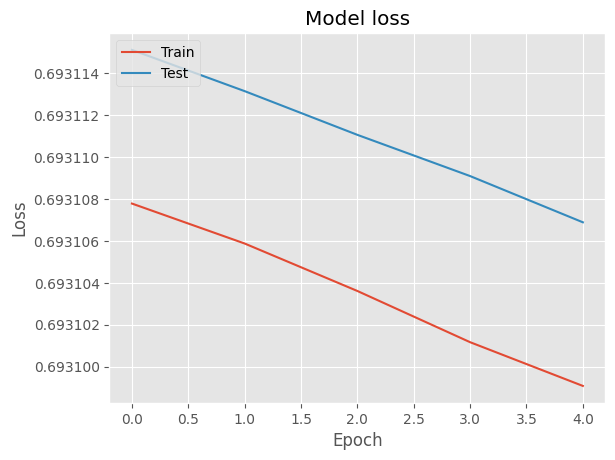

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 3

**Embedding --> LSTM --> Dense(Output(Sigmoid))**
- Same as Model 1, only batch_size different. With this model, the effect of batch size is observed.

**Using Adam optimizer**

In [ ]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
63/63 [==============================] - 52s 798ms/step - loss: 0.6177 - accuracy: 0.6814 - val_loss: 0.4726 - val_accuracy: 0.7840
Epoch 2/5
63/63 [==============================] - 51s 821ms/step - loss: 0.4162 - accuracy: 0.8367 - val_loss: 0.4279 - val_accuracy: 0.8317
Epoch 3/5
63/63 [==============================] - 70s 1s/step - loss: 0.3024 - accuracy: 0.8870 - val_loss: 0.2795 - val_accuracy: 0.8840
Epoch 4/5
63/63 [==============================] - 70s 1s/step - loss: 0.2196 - accuracy: 0.9179 - val_loss: 0.2774 - val_accuracy: 0.8947
Epoch 5/5
63/63 [==============================] - 59s 943ms/step - loss: 0.1868 - accuracy: 0.9319 - val_loss: 0.2698 - val_accuracy: 0.8923
Test Score: 0.26978129148483276
Test Accuracy: 0.8922500014305115
Accuracy: 89.23%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


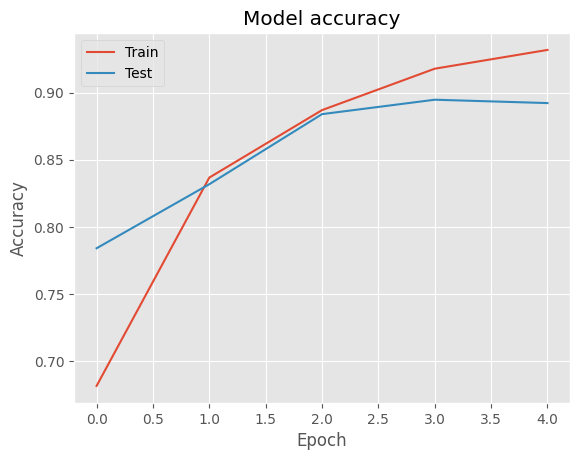

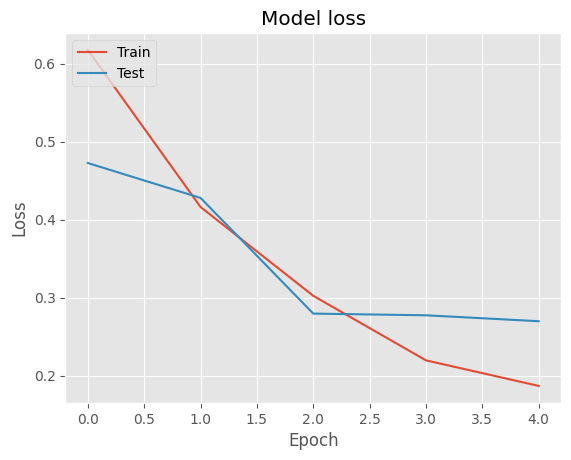

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 4

**Embedding --> LSTM --> LSTM --> Dense(Output(Sigmoid))**


In [ ]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 134s 1s/step - loss: 0.4434 - accuracy: 0.7748 - val_loss: 0.3063 - val_accuracy: 0.8662
Epoch 2/5
125/125 [==============================] - 125s 1s/step - loss: 0.2522 - accuracy: 0.9004 - val_loss: 0.2883 - val_accuracy: 0.8827
Epoch 3/5
125/125 [==============================] - 124s 989ms/step - loss: 0.2016 - accuracy: 0.9250 - val_loss: 0.2837 - val_accuracy: 0.8805
Epoch 4/5
125/125 [==============================] - 128s 1s/step - loss: 0.1709 - accuracy: 0.9365 - val_loss: 0.2867 - val_accuracy: 0.8857
Epoch 5/5
125/125 [==============================] - 122s 981ms/step - loss: 0.1543 - accuracy: 0.9449 - val_loss: 0.3083 - val_accuracy: 0.8777
Test Score: 0.30825987458229065
Test Accuracy: 0.8777499794960022
Accuracy: 87.77%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


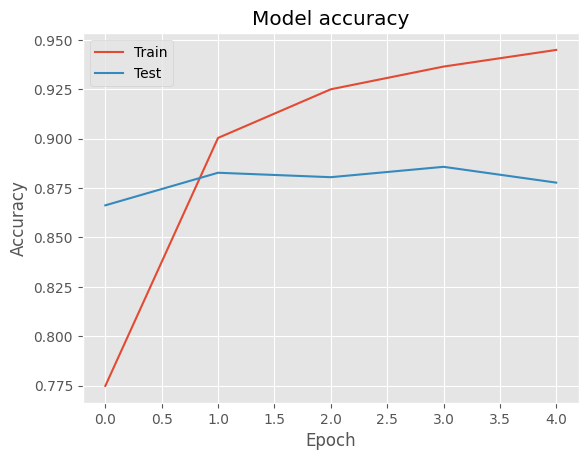

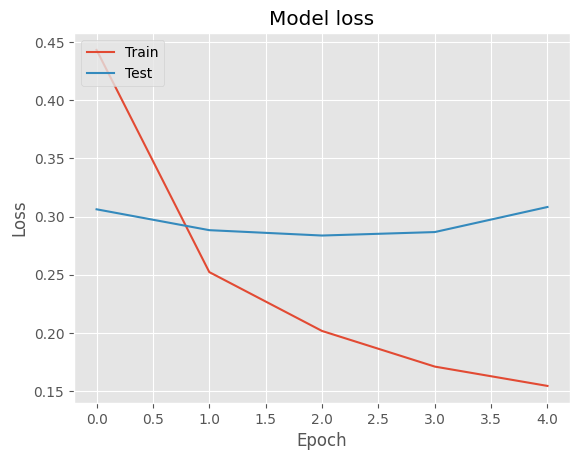

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 5

**Embedding --> LSTM --> Dropout --> LSTM --> Dropout --> Dense(Output(Sigmoid))**

In [ ]:
from keras.layers import Dropout
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 119s 927ms/step - loss: 0.4641 - accuracy: 0.7627 - val_loss: 0.2922 - val_accuracy: 0.8752
Epoch 2/5
125/125 [==============================] - 124s 996ms/step - loss: 0.2589 - accuracy: 0.8979 - val_loss: 0.2737 - val_accuracy: 0.8892
Epoch 3/5
125/125 [==============================] - 116s 926ms/step - loss: 0.2000 - accuracy: 0.9256 - val_loss: 0.2817 - val_accuracy: 0.8863
Epoch 4/5
125/125 [==============================] - 126s 1s/step - loss: 0.1767 - accuracy: 0.9361 - val_loss: 0.2867 - val_accuracy: 0.8875
Epoch 5/5
125/125 [==============================] - 117s 937ms/step - loss: 0.1513 - accuracy: 0.9449 - val_loss: 0.3179 - val_accuracy: 0.8852
Test Score: 0.3179164528846741
Test Accuracy: 0.8852499723434448
Accuracy: 88.52%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


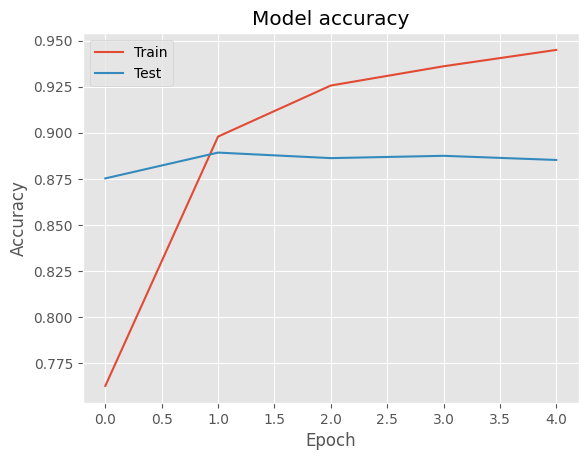

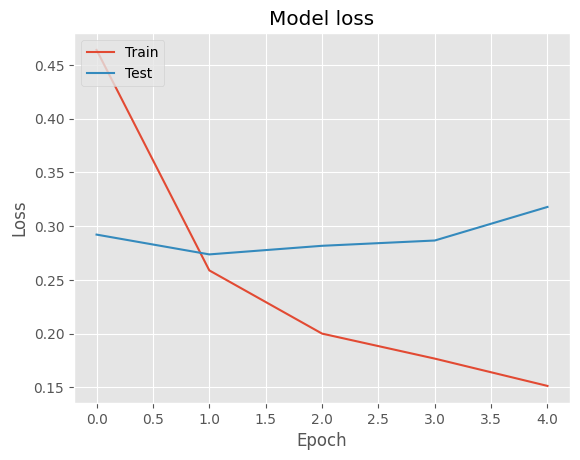

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model 6

**Embedding --> LSTM --> Dense(activation:Relu) --> Dense(Output(Sigmoid))**
- With this model, the effect of activation function is observed.

In [ ]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
# Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 55s 425ms/step - loss: 0.4747 - accuracy: 0.7526 - val_loss: 0.3129 - val_accuracy: 0.8687
Epoch 2/5
125/125 [==============================] - 65s 518ms/step - loss: 0.2524 - accuracy: 0.9018 - val_loss: 0.2758 - val_accuracy: 0.8880
Epoch 3/5
125/125 [==============================] - 79s 635ms/step - loss: 0.2030 - accuracy: 0.9229 - val_loss: 0.2699 - val_accuracy: 0.8940
Epoch 4/5
125/125 [==============================] - 54s 433ms/step - loss: 0.1723 - accuracy: 0.9381 - val_loss: 0.2992 - val_accuracy: 0.8845
Epoch 5/5
125/125 [==============================] - 54s 436ms/step - loss: 0.1448 - accuracy: 0.9489 - val_loss: 0.3273 - val_accuracy: 0.8905
Test Score: 0.3273351490497589
Test Accuracy: 0.890500009059906
Accuracy: 89.05%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


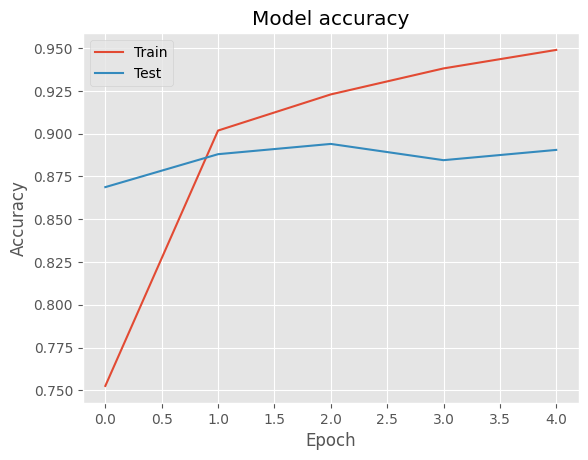

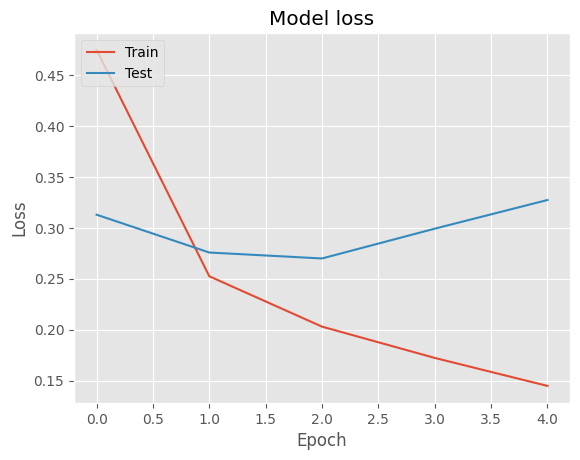

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Best model

In [ ]:
# Build Model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
result = model.evaluate(x_test, y_test, verbose=0)
#Results
print("Test Score:", result[0])
print("Test Accuracy:", result[1])
print("Accuracy: %.2f%%" % (result[1]*100))

Epoch 1/5
125/125 [==============================] - 55s 427ms/step - loss: 0.5360 - accuracy: 0.7336 - val_loss: 0.3810 - val_accuracy: 0.8303
Epoch 2/5
125/125 [==============================] - 55s 443ms/step - loss: 0.2993 - accuracy: 0.8746 - val_loss: 0.3041 - val_accuracy: 0.8765
Epoch 3/5
125/125 [==============================] - 53s 423ms/step - loss: 0.2194 - accuracy: 0.9158 - val_loss: 0.2615 - val_accuracy: 0.8947
Epoch 4/5
125/125 [==============================] - 54s 432ms/step - loss: 0.1771 - accuracy: 0.9351 - val_loss: 0.2744 - val_accuracy: 0.8957
Epoch 5/5
125/125 [==============================] - 53s 426ms/step - loss: 0.1672 - accuracy: 0.9384 - val_loss: 0.2890 - val_accuracy: 0.8823
Test Score: 0.2890235483646393
Test Accuracy: 0.8822500109672546
Accuracy: 88.23%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


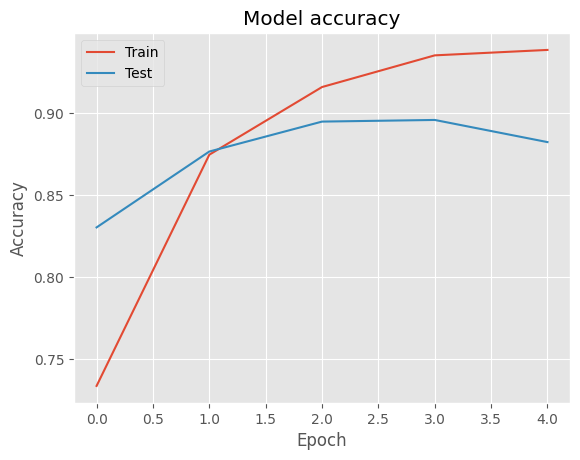

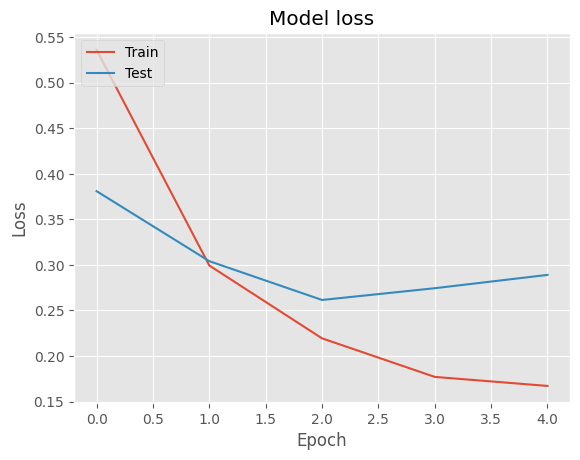

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Test

In [ ]:
import re
from keras.preprocessing import sequence

def preprocess_review(review):
    processed_review = review.lower()
    processed_review = re.sub(r'\d+', '', processed_review)
    processed_review = re.sub(r'[^\w\s]', ' ', processed_review)
    processed_review = processed_review.strip()
    return processed_review

def predict_sentiment(model, tokenizer, max_review_length, review):
    processed_review = preprocess_review(review)
    review_sequence = tokenizer.texts_to_sequences([processed_review])
    review_padded = sequence.pad_sequences(review_sequence, maxlen=max_review_length)
    predicted_sentiment = model.predict(review_padded)

    # Define thresholds for classifying as negative, neutral, and positive
    negative_threshold = 0.3
    positive_threshold = 0.7

    if predicted_sentiment < negative_threshold:
        predicted_class = "Negative"
    elif negative_threshold <= predicted_sentiment <= positive_threshold:
        predicted_class = "Neutral"

    else:
        predicted_class = "Positive"

    return predicted_class

sample_review = "Good but not so good"
predicted_sentiment = predict_sentiment(model, tokenizer, max_review_length, sample_review)
print("Sample Review:", sample_review)
print("Predicted Sentiment:", predicted_sentiment)


1/1 [==============================] - 0s 245ms/step
Sample Review: Good but not so good
Predicted Sentiment: Positive


# User Input

In [ ]:
from ipywidgets import widgets
from IPython.display import display
from IPython.display import display, HTML

# Function to handle button click event
def on_submit_button_click(btn):
    review = text_review.value
    if review.strip() == "":
        label_result.value = "Please enter a review."
    else:
        predicted_sentiment = predict_sentiment(model, tokenizer, max_review_length, review)
        label_result.value = "<p style='color: green; font-size: 16px;'>Predicted Sentiment: <strong>{}</strong></p>".format(predicted_sentiment)

# Create input text box for review
text_review = widgets.Textarea(rows=5)
text_review.layout.width = '50%'
display(text_review)

# Button to submit review
btn_submit = widgets.Button(description="Submit")
btn_submit.style.button_color = 'black'
btn_submit.on_click(on_submit_button_click)
display(btn_submit)

# Label to display predicted sentiment
label_result = widgets.HTML(value="")
display(label_result)

Textarea(value='', layout=Layout(width='50%'), rows=5)

Button(description='Submit', style=ButtonStyle(button_color='black'))

HTML(value='')

1/1 [==============================] - 0s 56ms/step
